In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class MCN(nn.Module):
    def __init__(self, num_classes_detection, num_classes_segmentation, num_keypoints):
        super(MCN, self).__init__()
        # Load a pre-trained ResNet backbone and remove the fully connected layer
        backbone = resnet18(pretrained=True)
        self.base_layers = nn.Sequential(*list(backbone.children())[:-2])  # Output: [B, 512, H/32, W/32]

        # Upsample to refine spatial resolution
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # Output: [B, 512, H/16, W/16]

        # Detection head
        self.detection_head = nn.Conv2d(512, num_classes_detection + 4, kernel_size=1)  # 4 extra channels for bounding boxes

        # Segmentation head with decoder
        self.segmentation_decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),  # Reduce channels
            nn.ReLU(),
            nn.Conv2d(256, num_classes_segmentation, kernel_size=1)  # Output: [B, num_classes_segmentation, H/16, W/16]
        )

        # Pose estimation head
        self.pose_head = nn.Conv2d(512, num_keypoints, kernel_size=1)  # Output: [B, num_keypoints, H/16, W/16]

    def forward(self, x):
        # Feature extraction
        features = self.base_layers(x)  # Output: [B, 512, H/32, W/32]

        # Upsample for higher resolution
        features = self.upsample(features)  # Output: [B, 512, H/16, W/16]

        # Detection output
        detection = self.detection_head(features)  # Output: [B, num_classes_detection + 4, H/16, W/16]
        detection_logits = detection[:, :-4, :, :]  # Class logits
        box_regressions = detection[:, -4:, :, :]  # Bounding box regressions

        # Segmentation output
        segmentation = self.segmentation_decoder(features)  # Output: [B, num_classes_segmentation, H/16, W/16]

        # Pose estimation output
        pose = self.pose_head(features)  # Output: [B, num_keypoints, H/16, W/16]

        return detection_logits, box_regressions, segmentation, pose


In [3]:
def compute_classification_loss(pred_logits, gt_classes, gt_boxes, grid_size):
    """
    Compute classification loss for detection head.

    Args:
    - pred_logits: Tensor of shape [num_classes, grid_h, grid_w], predicted logits.
    - gt_classes: Tensor of shape [N], remapped class indices for the ground truth.
    - gt_boxes: Tensor of shape [N, 4] in normalized coordinates.
    - grid_size: Tuple (grid_h, grid_w), matching pred_logits spatial dimensions.

    Returns:
    - classification_loss: Binary cross-entropy loss for predicted class probabilities.
    """
    grid_h, grid_w = grid_size
    num_classes = pred_logits.size(0)
    device = pred_logits.device

    # Initialize target tensor for classification loss
    target = torch.zeros((num_classes, grid_h, grid_w), device=device)

    for box, cls in zip(gt_boxes, gt_classes):
        x_min, y_min, x_max, y_max = box
        grid_x_min = int(x_min * grid_w)
        grid_y_min = int(y_min * grid_h)
        grid_x_max = int(x_max * grid_w)
        grid_y_max = int(y_max * grid_h)

        # Set the ground truth class in the target tensor
        target[cls, grid_y_min:grid_y_max, grid_x_min:grid_x_max] = 1.0

    # Compute binary cross-entropy loss
    return torch.nn.functional.binary_cross_entropy_with_logits(pred_logits, target)

def compute_loc_loss(pred_boxes, gt_boxes, grid_size):
    """
    Compute Smooth L1 loss for bounding box regression.

    Args:
    - pred_boxes: Predicted boxes of shape [4, grid_h, grid_w].
    - gt_boxes: Ground truth boxes of shape [N, 4].
    - grid_size: Tuple (grid_h, grid_w).

    Returns:
    - loc_loss: Smooth L1 loss.
    """
    grid_h, grid_w = grid_size
    pred_boxes = pred_boxes.permute(1, 2, 0).reshape(-1, 4)  # Reshape to [grid_h * grid_w, 4]
    num_boxes = gt_boxes.size(0)

    # If there are no ground truth boxes, return 0 loss
    if num_boxes == 0:
        return torch.tensor(0.0, device=pred_boxes.device)

    # Repeat ground truth boxes for all grid cells
    gt_boxes = gt_boxes.unsqueeze(0).expand(pred_boxes.size(0), -1, -1)  # [grid_h * grid_w, N, 4]
    pred_boxes = pred_boxes.unsqueeze(1).expand(-1, num_boxes, -1)  # [grid_h * grid_w, N, 4]

    # Compute pairwise Smooth L1 loss between predictions and ground truth
    pairwise_loss = torch.nn.functional.smooth_l1_loss(pred_boxes, gt_boxes, reduction="none").mean(dim=-1)  # [grid_h * grid_w, N]

    # Find the best match for each ground truth box
    matched_loss, _ = pairwise_loss.min(dim=0)  # [N]

    # Average over all ground truth boxes
    return matched_loss.mean()


def compute_segmentation_loss(pred_segmentation, gt_segmentation):
    # Cross-entropy loss for segmentation masks
    return torch.nn.functional.cross_entropy(pred_segmentation, gt_segmentation)

def compute_pose_loss(pred_pose, gt_pose):
    # Mean squared error for pose keypoints
    return torch.nn.functional.mse_loss(pred_pose, gt_pose)


In [4]:
def train(model, dataloader, optimizer, coco_to_model_mapping):
    model.train()
    total_loss = 0

    for batch_idx, (images, targets) in enumerate(dataloader):
        optimizer.zero_grad()

        # Unpack model outputs
        detection_logits, box_regressions, segmentation, pose = model(images)
        cumulative_loss = 0

        #print(f"Batch {batch_idx}:")
        #print(f"Image batch shape: {images.shape}")
        #print(f"Detection logits shape: {detection_logits.shape}")
        #print(f"Box regression shape: {box_regressions.shape}")
        #print(f"Segmentation output shape: {segmentation.shape}")
        #print(f"Pose output shape: {pose.shape}")

        grid_size = box_regressions.shape[-2:]  # (grid_h, grid_w)

        for i in range(images.size(0)):
            detection_loss = torch.tensor(0.0, device=images.device)
            segmentation_loss = torch.tensor(0.0, device=images.device)
            pose_loss = torch.tensor(0.0, device=images.device)

            # Detection loss
            if 'boxes' in targets and len(targets['boxes']) > i and targets['boxes'][i].nelement() > 0:
                gt_boxes = targets['boxes'][i]  # Shape: [N, 4]
                gt_classes = targets['category_ids'][i]  # Shape: [N]

                # Remap COCO category IDs to model class indices
                gt_classes = torch.tensor(
                    [coco_to_model_mapping[c.item()] for c in gt_classes],
                    device=images.device
                )

                detection_loss_cls = compute_classification_loss(
                    detection_logits[i], gt_classes, gt_boxes, grid_size
                )
                detection_loss_loc = compute_loc_loss(box_regressions[i], gt_boxes, grid_size)
                detection_loss = detection_loss_cls + detection_loss_loc
                print(f"Sample {i} - Detection loss: {detection_loss.item()}")

            # Segmentation loss
            if 'segmentation_masks' in targets and len(targets['segmentation_masks']) > i:
                gt_segmentation = targets['segmentation_masks'][i]
                segmentation_loss = compute_segmentation_loss(segmentation[i], gt_segmentation)
                print(f"Sample {i} - Segmentation loss: {segmentation_loss.item()}")

            # Pose loss
            if 'pose_keypoints' in targets and len(targets['pose_keypoints']) > i:
                gt_pose = targets['pose_keypoints'][i]
                pose_loss = compute_pose_loss(pose[i], gt_pose)
                print(f"Sample {i} - Pose loss: {pose_loss.item()}")

            # Total loss for the sample
            sample_loss = detection_loss + segmentation_loss + pose_loss
            print(f"Sample {i} - Total sample loss: {sample_loss.item()}")
            cumulative_loss += sample_loss

        # Backpropagation
        if cumulative_loss > 0:
            print(f"Batch {batch_idx} - Cumulative Loss Before Backprop: {cumulative_loss.item()}")
            cumulative_loss.backward()
            optimizer.step()

        total_loss += cumulative_loss.item()
        print(f"Batch {batch_idx} - Batch Loss: {cumulative_loss.item()}")

    print("Epoch completed.")
    return total_loss / len(dataloader)


In [5]:
import torch

def calculate_iou(pred, target):
    intersection = (pred & target).float().sum((1, 2))  # Intersection points
    union = (pred | target).float().sum((1, 2))         # Union points
    iou = (intersection + 1e-6) / (union + 1e-6)        # Add small epsilon to avoid division by zero
    return iou.mean()  # Mean IoU for the batch

def calculate_map(pred, target):
    # Placeholder for mAP calculation, you should implement or use a library for actual mAP calculation
    return torch.rand(1).item()

def calculate_pck(pred, target, threshold=0.1):
    # Placeholder for PCK calculation, implement based on your keypoints format
    return torch.rand(1).item()

def evaluate(model, dataloader):
    model.eval()
    total_iou = 0
    total_map = 0
    total_pck = 0
    total_batches = 0

    with torch.no_grad():
        for images, detection_targets, segmentation_targets, pose_targets in dataloader:
            detection_pred, segmentation_pred, pose_pred = model(images)

            # Thresholding predictions for evaluation
            detection_pred = torch.sigmoid(detection_pred) > 0.5
            segmentation_pred = torch.argmax(segmentation_pred, dim=1)  # Convert to class labels

            # Calculate metrics
            batch_iou = calculate_iou(segmentation_pred, segmentation_targets)
            batch_map = calculate_map(detection_pred, detection_targets)
            batch_pck = calculate_pck(pose_pred, pose_targets)

            total_iou += batch_iou
            total_map += batch_map
            total_pck += batch_pck
            total_batches += 1

    # Average the metrics over all batches
    avg_iou = total_iou / total_batches
    avg_map = total_map / total_batches
    avg_pck = total_pck / total_batches

    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average mAP: {avg_map:.4f}")
    print(f"Average PCK: {avg_pck:.4f}")

    return avg_iou, avg_map, avg_pck


## COCO Dataset

In [10]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip the downloaded files
!unzip -q train2017.zip -d /content/coco
!unzip -q annotations_trainval2017.zip -d /content/coco

# Optionally, clean up the downloaded zip files to save space
!rm train2017.zip
!rm annotations_trainval2017.zip

--2024-12-22 20:25:16--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.99, 52.217.232.25, 52.216.241.44, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  73.7MB/s    in 3m 33s  

2024-12-22 20:28:49 (86.5 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-12-22 20:28:49--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.24.4, 52.216.37.49, 52.216.52.233, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.24.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva

In [6]:
import os
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim

# Path to the COCO directory
coco_root = '/content/coco/'

transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to the same size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# COCO Detection datasets
train_dataset = CocoDetection(os.path.join(coco_root, 'train2017'),
                              os.path.join(coco_root, 'annotations', 'instances_train2017.json'),
                              transform=transform)

val_dataset  = CocoDetection(os.path.join(coco_root, 'val2017'),
                             os.path.join(coco_root, 'annotations', 'instances_val2017.json'),
                             transform=transform)

from torch.utils.data._utils.collate import default_collate
from torchvision.transforms.functional import to_tensor, resize
from torch.utils.data.dataloader import default_collate

from torchvision.transforms.functional import resize, normalize

def custom_collate(batch):
    images = [item[0] for item in batch]
    annotations = [item[1] for item in batch]

    processed_boxes = []
    processed_category_ids = []

    for annotation_list in annotations:
        if annotation_list:  # Check if annotations exist for the sample
            boxes = []
            category_ids = []
            for ann in annotation_list:
                # Extract `bbox` and `category_id`
                x_min, y_min, width, height = ann['bbox']
                x_max = x_min + width
                y_max = y_min + height
                boxes.append([x_min, y_min, x_max, y_max])
                category_ids.append(ann['category_id'])

            # Convert to tensors
            processed_boxes.append(torch.tensor(boxes, dtype=torch.float32))
            processed_category_ids.append(torch.tensor(category_ids, dtype=torch.int64))
        else:
            # Handle cases with no annotations
            processed_boxes.append(torch.zeros((0, 4), dtype=torch.float32))
            processed_category_ids.append(torch.zeros((0,), dtype=torch.int64))

    # Stack images and return processed annotations
    images = torch.stack(images)
    return images, {'boxes': processed_boxes, 'category_ids': processed_category_ids}


# Update DataLoader with the custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=custom_collate)


loading annotations into memory...
Done (t=26.96s)
creating index...
index created!
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


In [7]:
# Check a few annotations from the dataset
for i in range(5):
    _, sample_annotations = train_dataset[i]
    print(sample_annotations)
    if 'labels' in sample_annotations:
        print("Labels are present")
    else:
        print("Labels are missing")


[{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257.51, 393.04, 250.73, 407.72, 240.56, 425.79, 230.4, 441.6, 229.27, 447.25, 237.18, 447.25, 256.38, 456.28, 254.12, 475.48, 263.15, 486.78, 271.06, 49

In [12]:
for idx in range(5):
    image, annotation = train_dataset[idx]
    print(f"Sample {idx}:")
    print(f"  Image shape: {image.shape}")
    print(f"  Annotation: {annotation}")


Sample 0:
  Image shape: torch.Size([3, 512, 512])
  Annotation: [{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257.51, 393.04, 250.73, 407.72, 240.56, 425.79, 230.4, 441.6, 229.27, 447.25, 237.18, 4

In [6]:
def inspect_dataloader(dataloader, num_samples=5):
    for batch_idx, (images, targets) in enumerate(dataloader):
        print(f"Batch {batch_idx}:")
        print(f"Images shape: {images.shape}")

        for sample_idx in range(min(num_samples, len(targets['boxes']))):
            print(f"Sample {sample_idx}:")
            print(f"  Boxes:\n{targets['boxes'][sample_idx]}")
            print(f"  Category IDs:\n{targets['category_ids'][sample_idx]}")

        break  # Inspect only the first batch

inspect_dataloader(train_dataloader)


Batch 0:
Images shape: torch.Size([16, 3, 512, 512])
Sample 0:
  Boxes:
tensor([[233.4500, 194.4500, 385.5900, 388.9800]])
  Category IDs:
tensor([21])
Sample 1:
  Boxes:
tensor([[325.1900, 131.2000, 596.5500, 386.3400],
        [ 24.8500, 144.5600, 167.1500, 420.1400],
        [149.0800,  45.4600, 273.3200, 343.6200],
        [  2.1500,   1.7900, 639.2800, 471.0300]])
  Category IDs:
tensor([54, 58, 44, 67])
Sample 2:
  Boxes:
tensor([[431.1700, 182.2400, 468.7100, 227.4000],
        [186.9300,  12.0900, 243.9100,  92.0100],
        [207.6100,  13.0600, 305.4200, 143.7300],
        [473.7600, 123.0900, 523.1100, 280.2200],
        [436.2600, 121.1100, 457.8100, 151.4800],
        [331.6000, 118.3400, 339.0900, 136.4800],
        [299.7800, 106.9100, 325.3700, 138.7600],
        [153.9900, 119.2600, 171.1800, 145.5900],
        [ 98.2300, 127.4700, 108.3700, 137.6100],
        [143.8600, 125.6800, 169.8200, 150.9500],
        [ 26.3300, 126.8900,  59.2600, 169.7000],
        [508.6800,

[{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257.51, 393.04, 250.73, 407.72, 240.56, 425.79, 230.4, 441.6, 229.27, 447.25, 237.18, 447.25, 256.38, 456.28, 254.12, 475.48, 263.15, 486.78, 271.06, 49

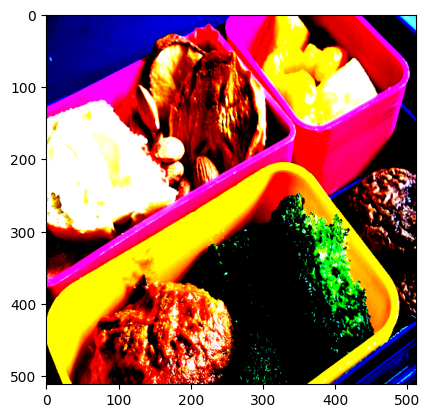

In [5]:
import matplotlib.pyplot as plt

# Load a single sample
image, annotation = train_dataset[0]
print(annotation)  # Print the annotation to see its structure

# Display the image
plt.imshow(image.permute(1, 2, 0))  # Rearrange channels for plotting
plt.show()


In [6]:
# Check the structure of annotations
sample_image, sample_annotations = train_dataset[0]
print(type(sample_annotations))  # Check the type
print(sample_annotations)  # Inspect the content

# Display a few more to confirm consistency
for i in range(1, 5):
    _, ann = train_dataset[i]
    print(ann)


<class 'list'>
[{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257.51, 393.04, 250.73, 407.72, 240.56, 425.79, 230.4, 441.6, 229.27, 447.25, 237.18, 447.25, 256.38, 456.28, 254.12, 475.48, 263.15, 486

In [7]:
from pycocotools.coco import COCO

# Path to the COCO annotations file
dataDir = '/content/coco'
dataType = 'train2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'

# Initialize COCO API for the specified annotations file
coco = COCO(annFile)

# Get all category names
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]

# Print the number of images for each class
print("Number of images per category:")
for category in categories:
    category_name = category['name']
    catId = category['id']
    imgIds = coco.getImgIds(catIds=[catId])
    print(f"{category_name}: {len(imgIds)} images")


loading annotations into memory...
Done (t=19.85s)
creating index...
index created!
Number of images per category:
person: 64115 images
bicycle: 3252 images
car: 12251 images
motorcycle: 3502 images
airplane: 2986 images
bus: 3952 images
train: 3588 images
truck: 6127 images
boat: 3025 images
traffic light: 4139 images
fire hydrant: 1711 images
stop sign: 1734 images
parking meter: 705 images
bench: 5570 images
bird: 3237 images
cat: 4114 images
dog: 4385 images
horse: 2941 images
sheep: 1529 images
cow: 1968 images
elephant: 2143 images
bear: 960 images
zebra: 1916 images
giraffe: 2546 images
backpack: 5528 images
umbrella: 3968 images
handbag: 6841 images
tie: 3810 images
suitcase: 2402 images
frisbee: 2184 images
skis: 3082 images
snowboard: 1654 images
sports ball: 4262 images
kite: 2261 images
baseball bat: 2506 images
baseball glove: 2629 images
skateboard: 3476 images
surfboard: 3486 images
tennis racket: 3394 images
bottle: 8501 images
wine glass: 2533 images
cup: 9189 images
f

In [ ]:
import os
import torch
import torch.optim as optim
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision import transforms

def custom_collate(batch, coco_to_model_mapping):
    images = [item[0] for item in batch]
    images = torch.stack(images)

    boxes = []
    category_ids = []
    for _, annotation in batch:
        gt_boxes = []
        gt_classes = []
        for ann in annotation:
            if 'bbox' in ann and 'category_id' in ann:
                x_min, y_min, width, height = ann['bbox']
                x_max = x_min + width
                y_max = y_min + height
                gt_boxes.append([x_min, y_min, x_max, y_max])

                # Map COCO category_id to model class index
                coco_id = ann['category_id']
                if coco_id in coco_to_model_mapping:
                    gt_classes.append(coco_to_model_mapping[coco_id])

        boxes.append(torch.tensor(gt_boxes, dtype=torch.float32))
        category_ids.append(torch.tensor(gt_classes, dtype=torch.long))

    # Convert to tensors
    if boxes:
        boxes = torch.nn.utils.rnn.pad_sequence(boxes, batch_first=True, padding_value=0)
    if category_ids:
        category_ids = torch.nn.utils.rnn.pad_sequence(category_ids, batch_first=True, padding_value=-1)

    return images, {'boxes': boxes, 'category_ids': category_ids}

def main():
    # Parameters and Hyperparameters
    num_epochs = 10
    learning_rate = 0.001
    batch_size = 16
    num_classes_detection = 80  # COCO dataset classes
    num_classes_segmentation = 21  # Example for segmentation tasks
    num_keypoints = 17  # COCO keypoints

    # COCO-to-Model Mapping
    coco_to_model_mapping = {
      1: 0,   # Person
      2: 1,   # Bicycle
      3: 2,   # Car
      4: 3,   # Motorcycle
      5: 4,   # Airplane
      6: 5,   # Bus
      7: 6,   # Train
      8: 7,   # Truck
      9: 8,   # Boat
      10: 9,  # Traffic Light
      11: 10, # Fire Hydrant
      13: 11, # Stop Sign
      14: 12, # Parking Meter
      15: 13, # Bench
      16: 14, # Bird
      17: 15, # Cat
      18: 16, # Dog
      19: 17, # Horse
      20: 18, # Sheep
      21: 19, # Cow
      22: 20, # Elephant
      23: 21, # Bear
      24: 22, # Zebra
      25: 23, # Giraffe
      27: 24, # Backpack
      28: 25, # Umbrella
      31: 26, # Handbag
      32: 27, # Tie
      33: 28, # Suitcase
      34: 29, # Frisbee
      35: 30, # Skis
      36: 31, # Snowboard
      37: 32, # Sports Ball
      38: 33, # Kite
      39: 34, # Baseball Bat
      40: 35, # Baseball Glove
      41: 36, # Skateboard
      42: 37, # Surfboard
      43: 38, # Tennis Racket
      44: 39, # Bottle
      46: 40, # Wine Glass
      47: 41, # Cup
      48: 42, # Fork
      49: 43, # Knife
      50: 44, # Spoon
      51: 45, # Bowl
      52: 46, # Banana
      53: 47, # Apple
      54: 48, # Sandwich
      55: 49, # Orange
      56: 50, # Broccoli
      57: 51, # Carrot
      58: 52, # Hot Dog
      59: 53, # Pizza
      60: 54, # Donut
      61: 55, # Cake
      62: 56, # Chair
      63: 57, # Couch
      64: 58, # Potted Plant
      65: 59, # Bed
      67: 60, # Dining Table
      70: 61, # Toilet
      72: 62, # TV
      73: 63, # Laptop
      74: 64, # Mouse
      75: 65, # Remote
      76: 66, # Keyboard
      77: 67, # Cell Phone
      78: 68, # Microwave
      79: 69, # Oven
      80: 70, # Toaster
      81: 71, # Sink
      82: 72, # Refrigerator
      84: 73, # Book
      85: 74, # Clock
      86: 75, # Vase
      87: 76, # Scissors
      88: 77, # Teddy Bear
      89: 78, # Hair Drier
      90: 79  # Toothbrush
    }


    # Model Initialization
    model = MCN(num_classes_detection, num_classes_segmentation, num_keypoints)
    if torch.cuda.is_available():
        model.cuda()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training
        train_loss = train(model, train_dataloader, optimizer, coco_to_model_mapping)
        print(f"Training Loss: {train_loss:.4f}")

        # Evaluation
        print("Evaluating...")
        val_loss = evaluate(model, val_dataloader)
        print(f"Validation Loss: {val_loss:.4f}")

    print("Training complete")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Sample 6 - Total sample loss: 43.451385498046875
Sample 7 - Detection loss: 34.626468658447266
Sample 7 - Total sample loss: 34.626468658447266
Sample 8 - Detection loss: 29.98897933959961
Sample 8 - Total sample loss: 29.98897933959961
Sample 9 - Detection loss: 23.2548828125
Sample 9 - Total sample loss: 23.2548828125
Sample 10 - Detection loss: 49.1369743347168
Sample 10 - Total sample loss: 49.1369743347168
Sample 11 - Total sample loss: 0.0
Sample 12 - Detection loss: 58.06035614013672
Sample 12 - Total sample loss: 58.06035614013672
Sample 13 - Detection loss: 24.49359130859375
Sample 13 - Total sample loss: 24.49359130859375
Sample 14 - Detection loss: 29.217727661132812
Sample 14 - Total sample loss: 29.217727661132812
Sample 15 - Detection loss: 45.343971252441406
Sample 15 - Total sample loss: 45.343971252441406
Batch 703 - Cumulative Loss Before Backprop: 615.0031127929688
Batch 703 - Batch Loss: 615.0031127929688
Batch 704:

### AIHWKit

In [ ]:
!pip install aihwkit >/dev/null
!wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.1+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl >/dev/null
!pip install aihwkit-0.9.1+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl >/dev/null